# Detecting Chihuahuas vs Muffins

A while ago I stumbled upon [this funny post by Mariya Yao](https://www.topbots.com/chihuahua-muffin-searching-best-computer-vision-api/amp/) which talks about a series of memes which put together completely unrelated objects that are very resembling to each other. It further compares different machine learning classification APIS to know which one correctly predicts best. 

Based on this, I wonder how good is a raw pretrained imagenet network using the pretrained network resnet34, provided by pytorch, using the fastai library. 
According to [this](https://pytorch.org/docs/stable/torchvision/models.html), the model has an accuracy of 73.3%. I will only test on these edge cases studied by Mariya.

Also, I wanted to show how little code is needed to do this using the [fastai](http://fast.ai) library. It is extraordinary how fast it can be! I also used the library to further train a model with a small set of muffin and chihuahuas images using transfer learning. 

This experiment was made using fast.ai 1.0.38 and Pytorch 1.0.

## Setup

I start by including the fastai libraries and setting up some other necessary code to make it look nicer in OSX

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *

In [2]:
# Use in case of retina display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [3]:
path = Path('/home/duguet/data/chihuahua-muffin')

Here, I set up my data folder. Inside this folder, the easiest way for me is to separate the classes in folders. This would be the structure:

In [4]:
path_string = str(path)
!tree -d $path_string

/home/duguet/data/chihuahua-muffin
├── models
├── other
├── test
│   ├── chihuahua
│   └── muffin
└── train
    ├── chihuahua
    └── muffin

8 directories


I created a folder `train` in which we are not interested right now for predicting, and a folder `test` which will have the images Mariya used for testing these algorithms. We see that for both folders, I created the subfolders `chihuahua` and `muffin`, which correspond to their different classes.

In [5]:
testset = path/'test'; trainset=path/'train'

In short, I downloaded the 16 images used for testing and put them in the `testset` folder.

In [6]:
!tree $path_string/test

/home/duguet/data/chihuahua-muffin/test
├── chihuahua
│   ├── test12.png
│   ├── test14.png
│   ├── test15.png
│   ├── test2.png
│   ├── test4.png
│   ├── test6.png
│   ├── test7.png
│   └── test9.png
└── muffin
    ├── test1.png
    ├── test10.png
    ├── test11.png
    ├── test13.png
    ├── test16.png
    ├── test3.png
    ├── test5.png
    └── test8.png

2 directories, 16 files


## Test ImageNet Pretrained Network 

The original Imagenet dataset was prepared to [detect  more than 20k categories](http://image-net.org/explore), but the [ILSVRC competition](http://image-net.org/challenges/LSVRC/2014/browse-synsets) which was the biggest image classification competition for years, used 1000 synsets (or classes) to classify. The model available for Pytorch (and inherited by the fastai library) is trained for this amount of classes. 

If you want to predict using the pretrained model, there are 2 ways to do that: the PyTorch way and the fastai way. 

### The PyTorch way

You need to download a file with the list of the classes of the model. You can find one [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [7]:
s = open('/home/duguet/data/imagenet/imagenet1000_clsid_to_human.txt', 'r')
imagenet_classes = eval(s.read())
#imagenet_classes = pickle.load(open('/home/duguet/data/imagenet/classes.pkl', 'rb'))

To use a model for prediction, it needs to be set into `eval` mode.

In [8]:
imagenet_model = models.resnet34(pretrained=True).eval()

We also need to find the class numbers corresponding to `chihuahua` and `muffin`.

In [9]:
print(list(imagenet_classes.values()).index('Chihuahua'))
print(list(imagenet_classes.values()).index('muffin'))

151


ValueError: 'muffin' is not in list

Unfortunately `muffin` is not in the list of the 1000 clases that the pretrained network provides. In the imagenet website, we see that muffin [appears to be in the misc subset](http://image-net.org/synset?wnid=n07690273). So the results for muffin will try to show the closest thing to it in the model. I'm curious to see what it is. 

We go over all the files in the test set (both subfolders) and print out their image and predicted class.

In [10]:
import glob

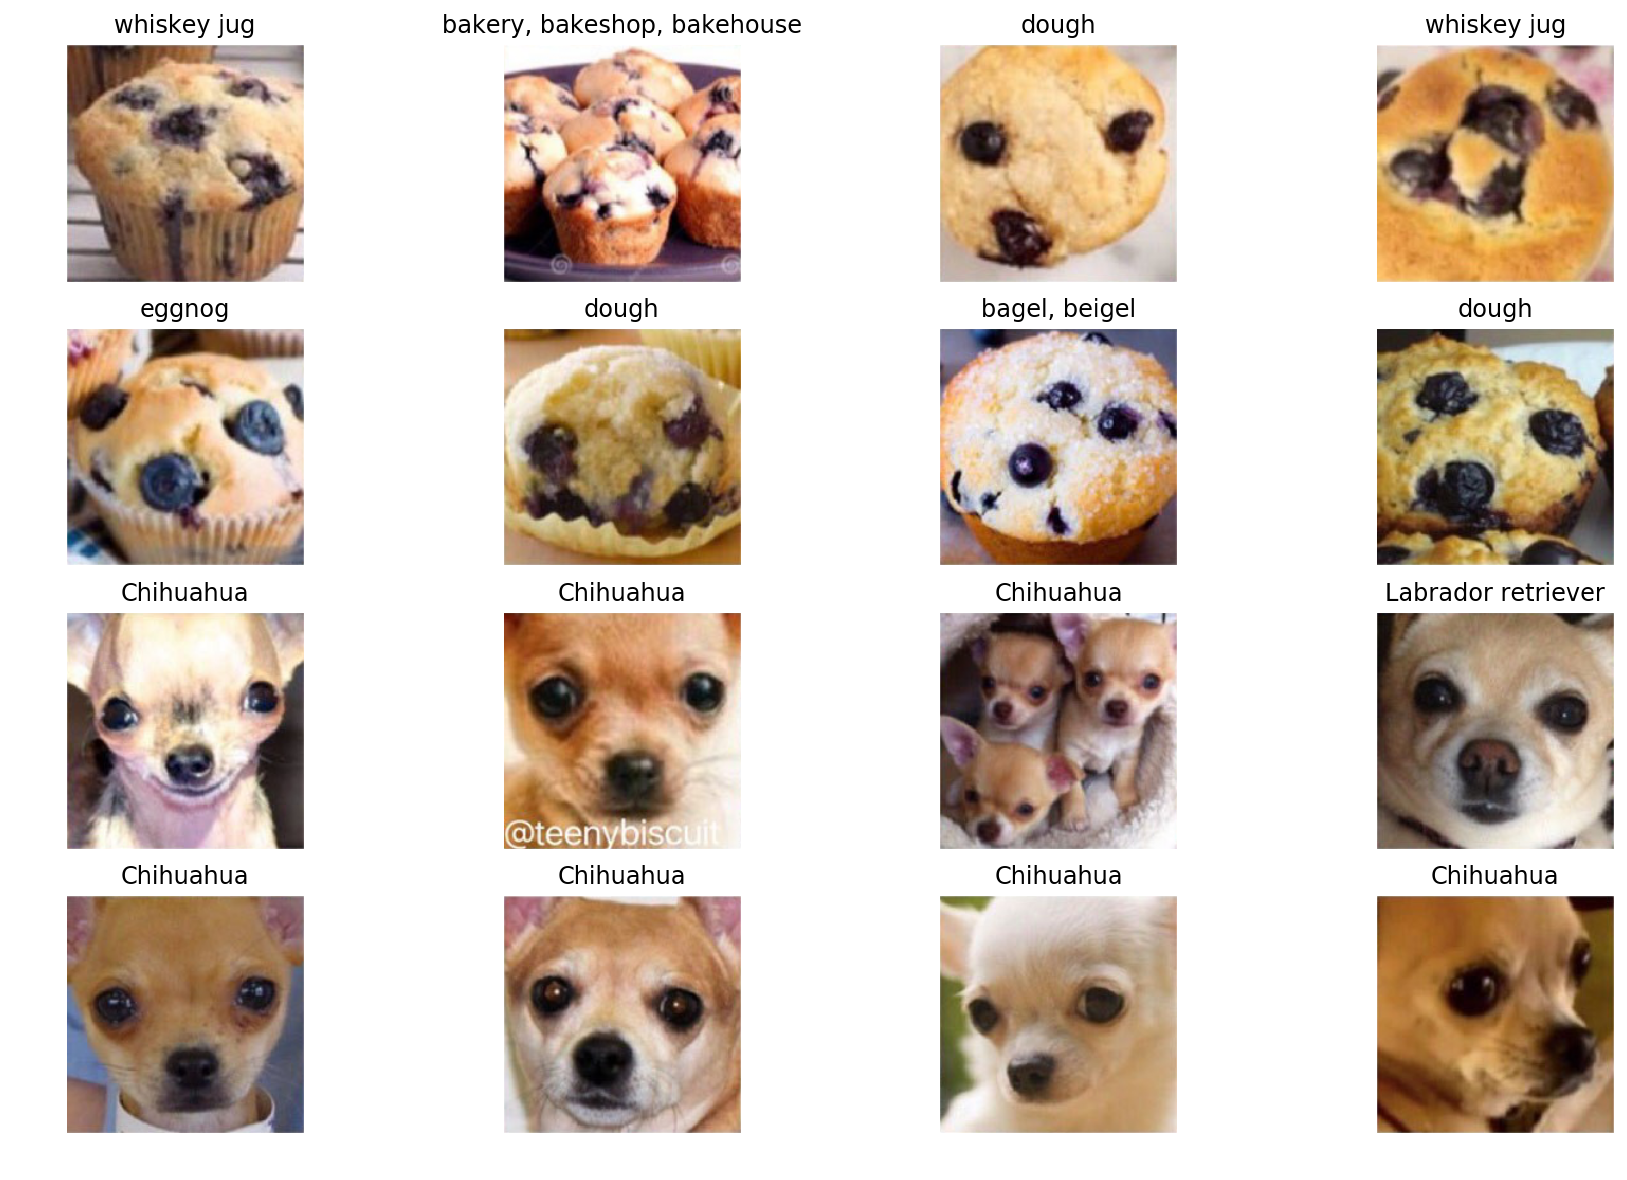

In [11]:
# Evaluate the old PyTorch way
testlist = glob.glob(str(testset/'*/*'))

fig,ax = plt.subplots(4,4,figsize=(15,10))

for i,ax_ in enumerate(ax.flatten()):
    try:
        img_file = testlist[i]
        img = open_image(img_file).resize(224)
        batch = torch.stack([img.data])
        out = imagenet_model(batch)
        solution = to_np(out.detach())
        idx = solution.argmax()
        img.show(ax=ax_, title=imagenet_classes[idx])
#         print(f'file: {img_file.name}. Detected {imagenet_classes[idx]}, {solution.max()}')
    except:
        continue

We can see all chihuahas except one are identified correctly. One was identified as a Labrador retriever :D. The muffin though, is identified as different classes, mainly `dough`, `whiskey jug`, `bagel,beigel`, and `bakery, bakeshop, bakehouse`. 

The most unrelated one is `whiskey jug`, which according to the imagenet dataset looks [completely different](http://image-net.org/synset?wnid=n04579145). Also, we see that bagel is one of the 1000 classes even though it [is also a part of the misc subset](http://image-net.org/synset?wnid=n07693725). 

### The fastai way

Unfortunately, it is not possible to use the fastai `learner` object to make predictions only using the resnet34 pretrained model. The reason is that the creation process of `create_cnn` actually strips the pretrained model from it's head (the last layers in charge of the classification) and create completely new layers of the type `Sequential()`, that might even not have the structure of the original architecture which was `ResNet()`.
Hence it is also not easy to load the ResNet weights into the learner. 

The only way to use the fast.ai approach is to train the model (for which we need training images) so we have non random weights in its head. We will do that in the next section. 

#### If you're still interested in seeing how it would work:

The fast.ai libary also has a way to let their `learn` object predict images, or batches. For that, a placeholder Databunch is created using `single_from_classes`.

In [16]:
data = ImageDataBunch.single_from_classes(path, list(imagenet_classes.values()), tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [17]:
learner = create_cnn(data, models.resnet34, pretrained=True)

In [15]:
# Evaluate the old PyTorch way
learner.model.eval()
for img_file in (testset/'muffin').ls():
    try:  
        img = open_image(img_file).resize(224)
        pred,_,_ = learner.predict(img)
        print(f'file: {img_file.name}. Detected {pred}')
    except:
        continue

file: test16.png. Detected sweatshirt
file: test5.png. Detected wreck
file: test13.png. Detected scale, weighing machine
file: test10.png. Detected French horn, horn
file: test8.png. Detected hook, claw
file: test3.png. Detected sweatshirt
file: test11.png. Detected ruddy turnstone, Arenaria interpres
file: test1.png. Detected sweatshirt


As we discussed before, with random weights on the model head, we get random values as well. 

## Train Network to Chihuahas and Muffins

Let's train the model for increasing accuracy as well as to see how does the prediction using the fast.ai methods work. 

For that, we need to create our own dataset of muffins and chihuahuas, and include them in our train folder. The fast.ai library also include some very handy scripts to make your own dataset of images using Google Images, inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/). 

Basically you get two text files with a list of image adresses. We go over them and download all files.

In [11]:
classes = ['chihuahua', 'muffin']

In [6]:
#Download images
for c in classes:
    download_images(path/f'{c}.txt', trainset/c, max_pics=700)

Error https://dechihuahua.org/wp-content/uploads/2018/10/chihuahua-en-el-rio.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error https://dechihuahua.org/wp-content/uploads/2018/11/bolsos-tienda.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error https://www.zooportraits.com/wp-content/uploads/2018/05/Chihuahua-Dog-Puppy-Canis-Lupus-Familiaris.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error https://dechihuahua.org/wp-content/uploads/2018/11/cuadro-pintura-rosa-color.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error https://dechihuahua.org/wp-content/uploads/2018/11/cuadros-tienda.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error https://dechihuahua.org/wp-content/uploads/2018/11/cuadro-chihuahua-7-300x300.jpg ('Connection aborte

We also verify the validity of the files.

In [7]:
# Verify images 
for c in classes:
    print(c)
    verify_images(trainset/c, delete=True, max_size=500)

chihuahua


muffin


Once we have gathered the images for training, creating a `DataBunch` is fairly straightforward.

In [33]:
# Create DataBunch
np.random.seed(42)
data= ImageDataBunch.from_folder(path, valid='test', ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

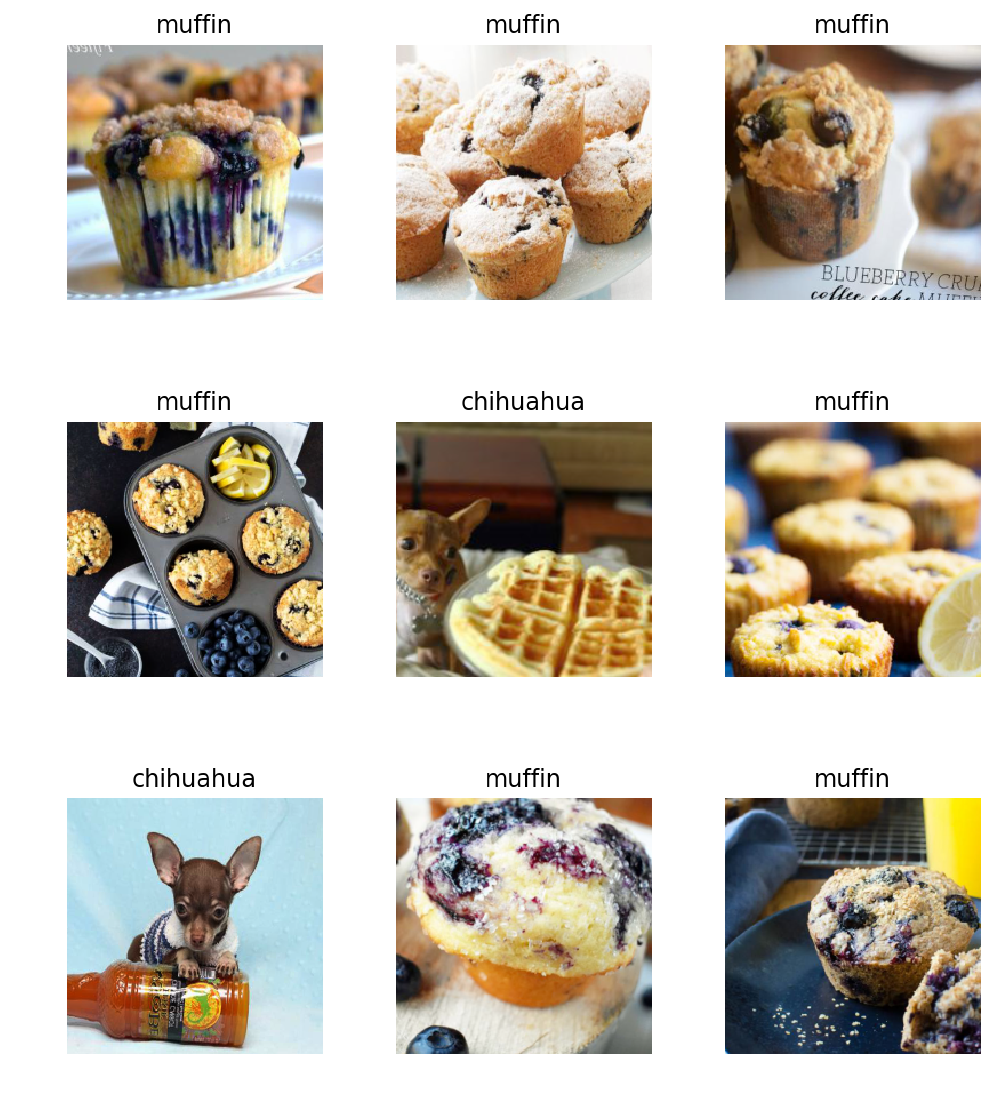

In [34]:
data.show_batch(rows=3, figsize=(7,8))

We see from the following, that we have 2 classes, 1270 images for training and 16 for validation (our images from the original exercise).

In [35]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['chihuahua', 'muffin'], 2, 1270, 16)

## Train model

We create the model and train in **only two lines!**.

In [36]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [37]:
learn.fit_one_cycle(4)

We see that the error is 0!!! The validation set is way too easy!! 

## Results

Once you have a trained learner objects, and if you have defined the images for validation, it is no longer necessary to individually predict them using the approach mentioned before. All we need to do is call `show_results`. 

In [38]:
acc = accuracy(*learn.get_preds()); acc.item()

1.0

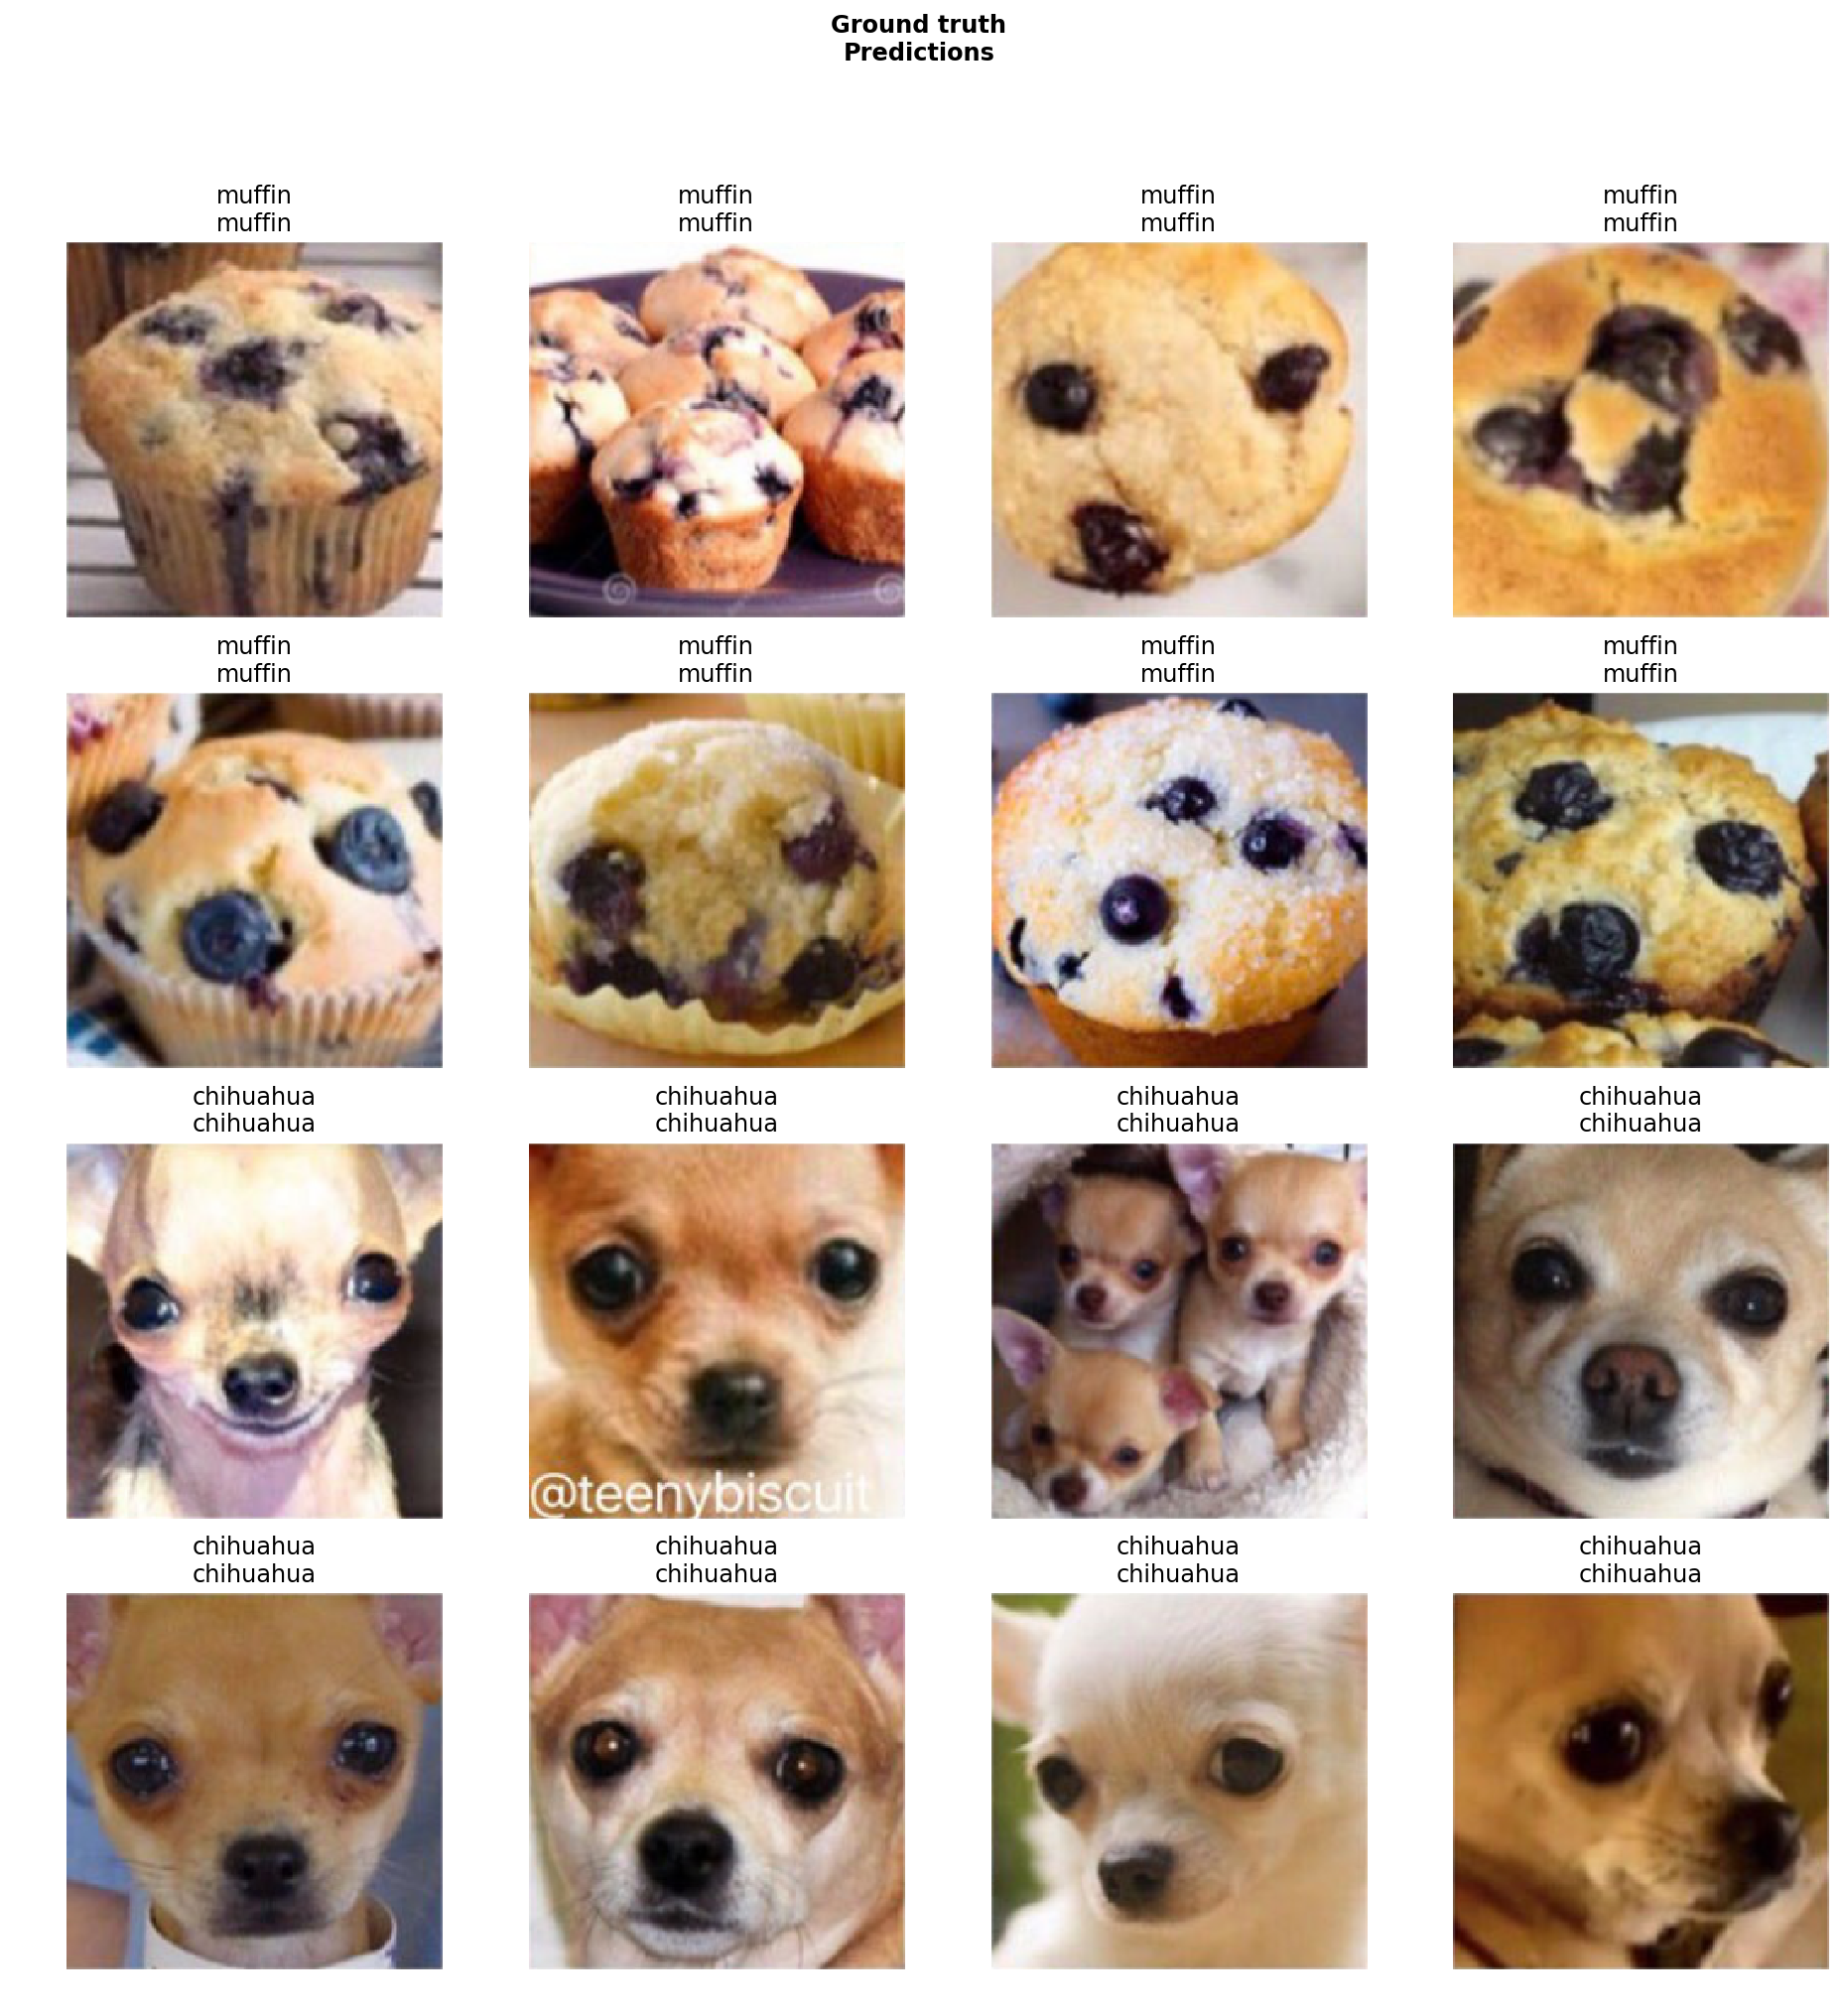

In [39]:
learn.show_results(rows=4)

Really, since we are only classifying between two objects, the problems becomes way too easy that all images are correctly predicted. As a disclaimer, I need to check if these iamges are not included in the automatically generated training set. Because, if they are there, of course that could be cheating.

In [40]:
interp = ClassificationInterpretation.from_learner(learn)

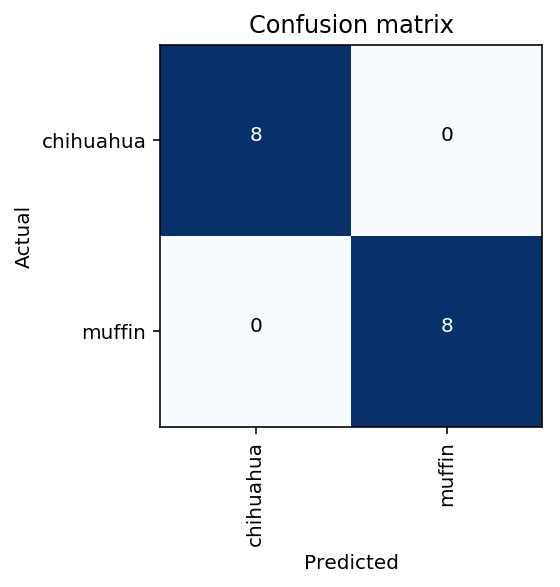

In [41]:
interp.plot_confusion_matrix()

### One last image for testing

Another image to confuse the model was used in by Mariya. It was an image of a chihuahuan AND a muffin. If we pass this to our trained model, we get:

In [42]:
img = open_image(path/'other/get.jpeg').resize(224)

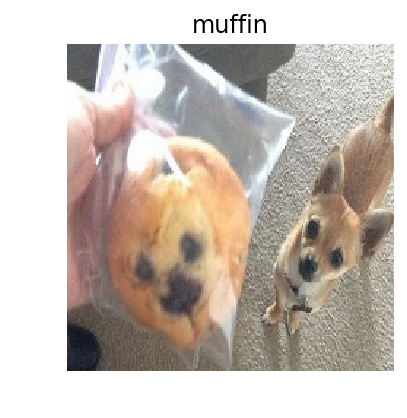

In [46]:
pred,_,_ = learn.predict(img)
img.show(title=pred)

Here, we see that the muffin wins. In order to detect both images here, we should implement a multiclasification network. 